In [ ]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris

np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)

# Reducción de dimensionalidad mediante filtrado

En este cuaderno se explican métodos de filtrado univariados.

Esto significa que para cada carecterística de la tabla de datos se calcula una puntuación (_score_) de cuanta relevancia tiene o de sus posibilidades para contribuir a realizar la tarea.

En el filtrado se eliminan todas aquellas características cuya puntuación no supera un umbral (_threshold_) elegido por nostros. <br>
Por este motivo también se dice que **son técnicas de selección de características**.

Vamos a aprender a filtrar por :
- varianza
- correlación
- información mutua

## Filtrado por varianza

La varianza es el promedio de las diferencias con la media elevadas al cuadrado.<br>
> Es decir, para una variable $x = [x_1, x_2, \ldots, x_N]$ con media $\mu$ (por ejemplo una característica), la varianza de $x$ es
$${\rm Var}(x) = \frac{1}{N} \sum\limits_{k=1}^N\left(\mu - x_k\right)^2.$$
<br>
Recuerda que la desviación estandar es la raíz cuadrada de la varianza
$$\sigma(x) = \sqrt{{\rm Var}(x)}.$$

El filtrado por varianza consiste en eliminar todas aquellas columnas cuya varianza no supere un cierto umbral.

**¿Qué ocurre si una característica tiene una varianza pequeña?**

Vamos a pensar en el caso extremo una columna con ${\rm Var}(x) = 0$ (más pequeña ya no puede ser).

Esto SÓLO ocurre si todos los valores de la columna son identicos, o sea $x_1=x_2=\cdots=x_N$.

¡¡ Esa columna NO está aportando nada !! <br>
Podríamos convertirla en una columna de unos simplemente dividiendo por el valor que se repite una y otra vez.

Sin llegar a ese extremo, cuanto más pequeña sea la varianza menos variabilidad hay en la característica para la que se calcula. <br>
Una columna sin variabilidad es una columna "casi constante" es decir que varía muy poco, por lo que es muy probable que no aporte nada a la hora de construir una máquina para tareas de ML.

El umbral que fijamos debe ser relativamente bajo para asegurar esa condición.

| |
|:---:|
|**¡ &nbsp; _Cuidado_ &nbsp; !**|


La varianza es **sensible** al orden de magnitud de los datos.<br>
En concreto, si $c$ es una constante, entonces $~{\rm Var}(c·X) = c^2·{{\rm Var}}(x).$<br>
Es decir, si escalamos los datos al intervalo unidad, estaremos cambiando su varianza.


**Implementación en Python**

<u>Cálculo de la varianza en Pandas</u><br>
  - Se utiliza el método `var()` de un dataframe.<br>
  - Por defecto se calcula la _varianza de la muestra_, que divide entre $N-1$.
  - Se puede modificar con la opción `ddof=0`. En ese casi estaríamos dividiendo entre $N$ y calculando la _varianza de la población_.
  
<u>Filtrado por varianza en Scikit-Learn</u><br>
  - Se utiliza `sklearn.feature_selection.VarianceThreshold`. <br>
  - El propio método calcula la varianza poblacional de los datos.

### Ejemplo
Vamos a utilizar el método `sklearn.feature_selection.VarianceThreshold` con un ejemplo de juguete para mostrar sus limitaciones y ver los problemas que surgen.

Comenzamos creando un dataframe de juguete y mostrando la varianza de cada característica.<br>
Después filtramos el dataframe.

In [ ]:
# ejemplo de filtrado por varianza

def print_info(df):
  print(df)
  print(f'\nLa varianza de cada característica es')
  print(df.var(ddof=0))

dfoo = pd.DataFrame({
    'x1': [1, 5, 10, 15, 20],
    'x2': [0.01, 0.05, 0.1, 0.15, 0.2],
    'x3': [1001, 1005, 1010, 1015, 1020]
})

threshold=0.1

selector = VarianceThreshold(threshold=threshold)
selector.set_output(transform="pandas")
selector.fit(dfoo)
df_filtered = selector.transform(dfoo)


print(f'El dataframe original es:')
print_info(dfoo)
print(f'\n-----------\n')
print(f'El dataframe filtrado por varianza > {threshold}:')
print_info(df_filtered)

El dataframe original es:
   x1    x2    x3
0   1  0.01  1001
1   5  0.05  1005
2  10  0.10  1010
3  15  0.15  1015
4  20  0.20  1020

La varianza de cada característica es
x1    46.1600
x2     0.0046
x3    46.1600
dtype: float64

-----------

El dataframe filtrado por varianza > 0.1:
     x1      x3
0   1.0  1001.0
1   5.0  1005.0
2  10.0  1010.0
3  15.0  1015.0
4  20.0  1020.0

La varianza de cada característica es
x1    46.16
x3    46.16
dtype: float64


En la celda de arriba podemos ver que hemos eliminado $x_2$, pero **¿hemos hecho lo correcto?**

La varianza es sensible a la escala. <br>
Como $x_2=10^{-2}·x_1~$,  entonces $~{\rm Var}(x_2) = {\rm Var}(10^{-2}·x_1) = 10^{-4}·{\rm Var}(x_1)$

Por otro lado, $x_3 = 1000 + x_1.$

| Propiedades de la varianza                  |
|---------------------------------------------|
| ${\rm Var}(c) = 0$                          |
| ${\rm Var}(X+Y)$ $=$ ${\rm Var}(X)+{\rm Var}(Y)$  |  

Juntando ambas propiedades tenemos que ${\rm Var}(x_3) = {\rm Var}(1000 + x_1)) = {\rm Var}(1000)+{\rm Var}(x_1) = {\rm Var}(x_1)$

**Es un buen momento para repensar nuestro preprocesado de datos**

¿Cuál sería más conveniente de los tres que conocemos?

Todos los valores son positivos, así que si dividimos cada columna por su máximo nos aseguramos de que los valores transformados son todos menores o iguales a 1.

Entonces la varianza de cada columna dependerá de hasta donde es capaz de bajar el mínimo, que será siempre mayor o igual que cero.

En el ejemplo de arriba, la diferencia entre 1020 y 1000 es mucho menor, en términos relativos al mayor (o sea 1020), que entre 20 y 1 o entre .2 y .01.

En la celda de abajo podemos ver el resultado.

In [ ]:
# repetimos el ejemplo PERO escalando al intervalo unidad antes del filtrado

scaler = MaxAbsScaler()
scaler.set_output(transform='pandas')
scaler.fit(dfoo)
df_scaled = scaler.transform(dfoo)

selector.fit(df_scaled)
df_filtered = selector.transform(df_scaled)


print(f'El dataframe escalado respecto del máximo de cada característica es:')
print_info(df_scaled)
print(f'\n-----------\n')
print(f'El dataframe escalado y filtrado por varianza > {threshold}:')
print_info(df_filtered)

El dataframe escalado respecto del máximo de cada característica es:
     x1    x2      x3
0  0.05  0.05  0.9814
1  0.25  0.25  0.9853
2  0.50  0.50  0.9902
3  0.75  0.75  0.9951
4  1.00  1.00  1.0000

La varianza de cada característica es
x1    1.1540e-01
x2    1.1540e-01
x3    4.4368e-05
dtype: float64

-----------

El dataframe escalado y filtrado por varianza > 0.1:
     x1    x2
0  0.05  0.05
1  0.25  0.25
2  0.50  0.50
3  0.75  0.75
4  1.00  1.00

La varianza de cada característica es
x1    0.1154
x2    0.1154
dtype: float64


## Filtrado por correlación

Si dos características están correlacionadas significa que entre ambas existe una relación lineal. <br>
Es decir, cuando una crece o decrece, la otra lo hace proporcionalmente.<br>
Por tanto no necesitamos ambas, basta con una de ellas porque la otra nos aporta exactamente la misma información, salvo por una escala y, quizás, un desplazamiento (_offset_).

Pero esto sólo ocurre si la correlación entre ambas es $+1$ o $-1$. <br>
Cuanto más cerca a los extremos, más correlación; y cuanto más cerca a $0$, menos correlación.

Así que otro modo de filtrar características es obtener la matriz de correlación y buscar las celdas de la matriz próximas a $+1$ o $-1$.<br>
Supongamos que $~\rho_{ij}={\rm Corr}(x_i,x_j)~$  es la correlación entre las características $x_i$ y $x_j$, si $~|\rho_{ij}|\simeq 1~$ entonces podemos eliminar $x_i$ o $x_j$.

Por ejemplo, en el DataFrame de juguete `dfoo` de arriba, la correlación de cualquier par de características es 1.

Matriz de correlación de dfoo
     x1   x2   x3
x1  1.0  1.0  1.0
x2  1.0  1.0  1.0
x3  1.0  1.0  1.0


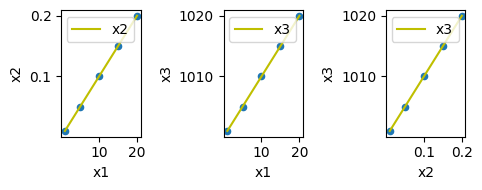

In [ ]:
# matriz de correlación
print('Matriz de correlación de dfoo')
print(dfoo.corr())

# mostramos que efectivamente existe una dependencia lineal
#  entre cada par de características

fig, axes = plt.subplots(1, 3, figsize=(5,2) )
dfoo.plot(kind = 'line', x='x1',y='x2', c='y', ax=axes[0])
dfoo.plot(kind = 'scatter', x='x1',y='x2', ax=axes[0])
dfoo.plot(kind = 'line', x='x1',y='x3', c='y', ax=axes[1])
dfoo.plot(kind = 'scatter', x='x1',y='x3', ax=axes[1])
dfoo.plot(kind = 'line', x='x2',y='x3', c='y', ax=axes[2])
dfoo.plot(kind = 'scatter', x='x2',y='x3', ax=axes[2])
fig.tight_layout()

En problemas supervisados también se tiene en cuenta la correlación entre las características y la etiqueta o valor objetivo (_target_).

Pero en este caso nos interesa **conservar** aquellas características que tengan una correlación muy alta respecto al _target_.

#### Ejemplo

Dataframe
   x1   x2   x3  y
0   1  3.0  -50  1
1   5 -2.0  200  1
2   3  8.0  300  1
3   2 -0.5 -400  0
4   8 -1.0 -300  0

Matriz de correlación
        x1      x2      x3       y
x1  1.0000 -0.4513 -0.1185 -0.3948
x2 -0.4513  1.0000  0.5473  0.5019
x3 -0.1185  0.5473  1.0000  0.9005
y  -0.3948  0.5019  0.9005  1.0000


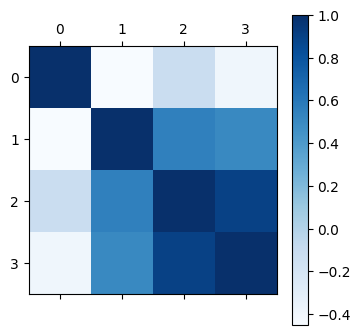

In [ ]:
df = pd.DataFrame({
    'x1': [1, 5, 3, 2, 8],
    'x2': [3, -2, 8, -0.5, -1],
    'x3': [-50, 200, 300, -400, -300],
    'y' : [1, 1, 1, 0, 0]
})
corr_mat = df.corr()

print("Dataframe")
print(df)
print("\nMatriz de correlación")
print(corr_mat)

plt.matshow(corr_mat, cmap='Blues')
plt.colorbar()
plt.show()

Se puede ver que $x_3$ tiene una correlación mayor de 0.9 con $y$. <br>
Por tanto interesa conservar $x_3$ y, si fuera necesario, eliminar las otras.
| |
|:---:|
|**¡ &nbsp; _Importante_ &nbsp; !**|
El filtrado por correlación tiene dos características importantes:
- No se ve afectado por la escala.<br>
  Puedes comprobar esto en el ejemplo, donde $x_3$ tiene un orden de magnitud dos veces mayor que las otras características.
- Es más eficiente en problemas de regresión que en problemas de clasificación.

## Filtrado por información mutua

La información mutua o ganancia de información  mide la reducción de la incertidumbre (entropía) de una variable aleatoria $X$ cuando se conoce el valor de otra $Y$.

_Información mutua_ y _Entropía_ son conceptos que  pertenecen a la Teoría de la Información, y son la base teórica de los árboles de decisión. Por tanto dejamos esta técnica para más adelante, cuando expliquemos ese tema.

# Ejemplo

A lo largo de este ejemplo utilizaremos el famoso conjunto de datos "Iris".

Este conjunto consiste en una tabla donde se han recogido 150 ejemplos de tres tipos de Iris (una flor): _Setosa_, _Versicolor_, _Virgínica_.<br>
En la figura de abajo se muestra una foto de cada una.

Cada ejemplo viene descrito por 4 atributos:
- Longitud del sépalo
- Anchura del sépalo
- Longitud del pétalo
- Anchura del pétalo


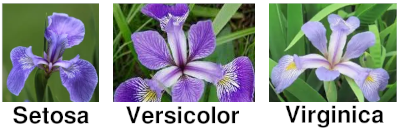

In [ ]:
# Load the Iris dataset and create a DataFrame
iris_data = load_iris()
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [ ]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.0000,150.0000,150.0000,150.0000
mean,5.8433,3.0573,3.7580,1.1993
std,0.8281,0.4359,1.7653,0.7622
min,4.3000,2.0000,1.0000,0.1000
25%,5.1000,2.8000,1.6000,0.3000
50%,5.8000,3.0000,4.3500,1.3000
75%,6.4000,3.3000,5.1000,1.8000
max,7.9000,4.4000,6.9000,2.5000


De la exploración de los datos apreciamos que:
- no hay valores perdidos
- no hay valores negativos
así que vamos a aplicar `MaxAbsScaler`

In [ ]:
scaler = MaxAbsScaler().set_output(transform='pandas')
scaler.fit(iris_df)
iris_scl = scaler.transform(iris_df)
iris_scl.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.0000,150.0000,150.0000,150.0000
mean,0.7397,0.6948,0.5446,0.4797
std,0.1048,0.0991,0.2558,0.3049
min,0.5443,0.4545,0.1449,0.0400
25%,0.6456,0.6364,0.2319,0.1200
50%,0.7342,0.6818,0.6304,0.5200
75%,0.8101,0.7500,0.7391,0.7200
max,1.0000,1.0000,1.0000,1.0000


In [ ]:
# en esta celda hacemos un filtrado por varianza

threshold = 0.01

selector = VarianceThreshold(threshold=threshold)
selector.set_output(transform="pandas")
selector.fit(iris_scl)
filtered_df = selector.transform(iris_scl)


print('Tras el MaxAbsScaler, \n las varianzas de cada característica son:\n')
print(iris_scl.var(ddof=0))
print(f'\n y la tabla filtrada por varianza > {threshold} es:\n')
print(filtered_df)

Tras el MaxAbsScaler, 
 las varianzas de cada característica son:

sepal length (cm)    0.0109
sepal width (cm)     0.0097
petal length (cm)    0.0650
petal width (cm)     0.0923
dtype: float64

 y la tabla filtrada por varianza > 0.01 es:

     sepal length (cm)  petal length (cm)  petal width (cm)
0               0.6456             0.2029              0.08
1               0.6203             0.2029              0.08
2               0.5949             0.1884              0.08
3               0.5823             0.2174              0.08
4               0.6329             0.2029              0.08
..                 ...                ...               ...
145             0.8481             0.7536              0.92
146             0.7975             0.7246              0.76
147             0.8228             0.7536              0.80
148             0.7848             0.7826              0.92
149             0.7468             0.7391              0.72

[150 rows x 3 columns]


A continuación vamos a analizar las correlaciones entre características


Matriz de correlación
                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)             1.0000           -0.1176             0.8718   
sepal width (cm)             -0.1176            1.0000            -0.4284   
petal length (cm)             0.8718           -0.4284             1.0000   
petal width (cm)              0.8179           -0.3661             0.9629   

                   petal width (cm)  
sepal length (cm)            0.8179  
sepal width (cm)            -0.3661  
petal length (cm)            0.9629  
petal width (cm)             1.0000  


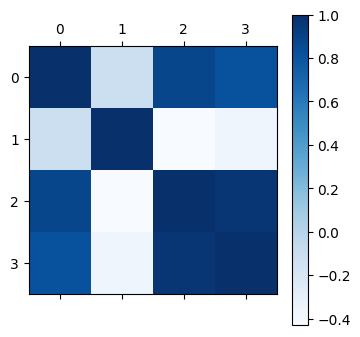

In [ ]:
corr_mat = iris_df.corr()

print("\nMatriz de correlación")
print(corr_mat)

plt.matshow(corr_mat, cmap='Blues')
plt.colorbar()
plt.show()

Se puede apreciar que la característica número 2 y 3 (_petal length_ y _petal width_) están muy correlacionadas ($r=0.9629$) por lo que podríamos prescindir de una de ellas.

In [ ]:
# en esta celda hacemos un filtrado por correlación con la etiqueta (target)

target = pd.DataFrame(iris_data.target, columns=['target'])
df_extended = pd.concat([iris_df, target], axis=1)

corr_mat = df_extended.corr()

print("\nTabla con la columna 'Target'")
print(df_extended)
print("\nCorrelación de 'target' con: ")
print(corr_mat["target"])


Tabla con la columna 'Target'
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8 

Podemos ver que la correlación entre la etiqueta y las características _petal length_ y _petal width_ es superior a 0.94.

Previamente ya habíamos obtenido que precisamente estas dos características estaban muy correlacionadas, por lo que eran redundantes y se podía eliminar una.

Como _petal width_ tiene un coeficiente de correlación un poco mayor, nos quedamos con ella.

Por otro lado también habíamos visto que _sepal width_ tenía una varianza menor del 2% respecto del máximo valor que toma, y además vemos que no tiene una correlación muy alta.

En conclusión, nos quedamos con 2 características: {_sepal length_ ,&nbsp; _petal width_}. Y si tuvieramos que elegir una de las dos sería _petal width_.

---

A lo largo de este ejemplo hemos utilizado el conjunto tal cual lo hemos descargado. <br>
Como sabemos, es importante reservar una parte del conjunto para probar nuestras máquinas. <br>
No lo hemos hecho porque aún no estamos entrenando modelos. Pero puedes repetir el ejemplo haciendo la separación en _entrenamiento_ y _validación_.  <br>
Además, en los ejercicios de este cuaderno hay uno en el que se exije.

# Ejercicios

Añadir al dataframe `iris_df` del ejemplo sólo las características polinómicas con interacción y un par de características creadas manualmente. Después hacer un filtrado.

Repetir el ejercicio anterior pero ANTES del filtrado realiza una estandarización.
- ¿Da el mismo resultado?
- ¿Por qué?
- Como conclusión de este ejercicio responde: ¿cuál de los dos procesos se debería hacer SIEMPRE ANTES que el otro? ¿por qué?

Repetir el ejercicio anterior, pero ahora haciendo un escalado al intervalo unidad.

Observa los resultados en comparación con el ejemplo de arriba y el ejercicio anterior. ¿Qué conclusiones tienes?

Repetir el primer ejercicio pero ahora:
- Descarga de internet el conjunto de datos [_Student Performance_](https://archive.ics.uci.edu/static/public/320/student+performance.zip).<br>
[Aquí](https://archive.ics.uci.edu/dataset/320/student+performance) puedes encontrar información sobre los datos.
- Separa el conjunto de datos en dos (entrenamiento y test)
- Sobre el conjunto de entrenamiento:
  - Haz un aumento de dimensionalidad creando nuevas características
  - Evalua la posibilidad de hacer una selección de características
- Transforma del conjunto de test de la misma manera que transformaste el conjunto de entrenamiento.